In [90]:
# Imports
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import statsmodels.api as sm
from prophet.plot import add_changepoints_to_plot

## Exercises

Let's consider a time series of monthly retail sales index in the Netherlands from 1960 to 1995.

1. Do the required preproccesing and convert the data to Prophet format.
2. Split the data in training and test data, using the first 90% and last 10% of the time series, respectively.
3. Fit a Prophet model to the data using a linear trend and make a forecast for the period of the test data.
4. Make the forecast with a model that includes the national holidays.
5. Adjust the trend by modifying the `changepoint_range` and `changepoint_prior_scale`. For each parameter, try at least two different values from the default ones.
6. Make the forecasts with a model with logistic trend.
7. Compare the performance of the models obtained at steps 3-6 in terms of MSE and MAPE on the test data.

In [91]:
sales = sm.datasets.get_rdataset("DutchSales", "AER").data
print("Raw data:\n------------------\n", sales.head())

Raw data:
------------------
           time  value
0  1960.333333     14
1  1960.416667     13
2  1960.500000     15
3  1960.583333     13
4  1960.666667     13


### Point 1 + 2 + 3

1) Convert date in prophet format and change data column name.
2) Split as always

In [92]:
# Convert decimal year to pandas datetime
def convert_decimal_year_to_datetime(decimal_years):
    dates = [(pd.to_datetime(f'{int(year)}-01-01') + pd.to_timedelta((year - int(year)) * 365.25, unit='D')).date() 
             for year in decimal_years]
    return dates

# Convert to Prophet format
converted_sales = pd.DataFrame()
converted_sales['ds'] = convert_decimal_year_to_datetime(sales['time'])
converted_sales['y'] = sales['value']

# Convert the column ds to datetime
converted_sales['ds'] = pd.to_datetime(converted_sales['ds'])

11:41:50 - cmdstanpy - INFO - Chain [1] start processing
11:41:50 - cmdstanpy - INFO - Chain [1] done processing


Text(133.09722222222223, 0.5, 'Sales')

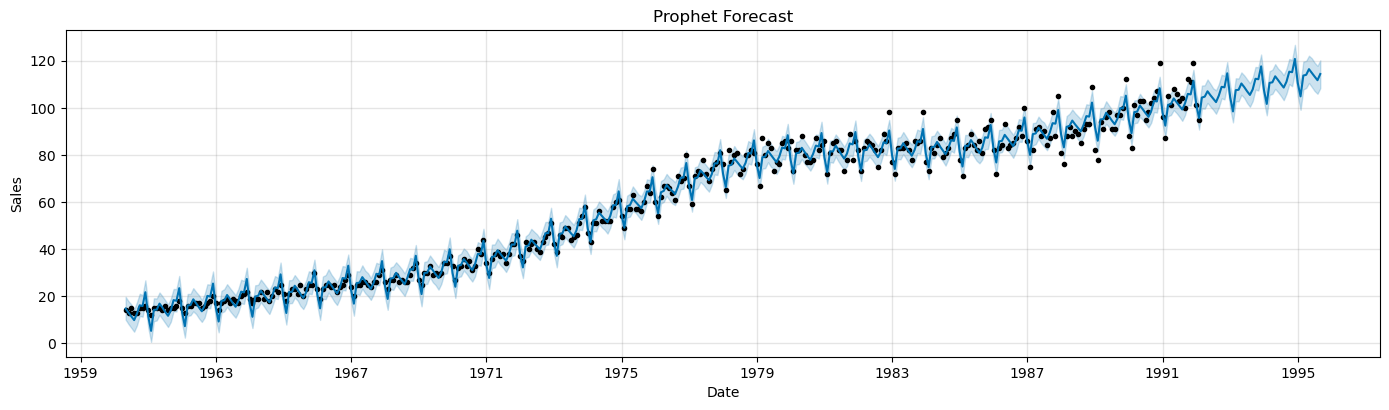

In [93]:
total_len = len(converted_sales)
train_len = int(total_len * 0.9)
train = converted_sales[:train_len]
test = converted_sales[train_len:]

model = Prophet(growth='linear', seasonality_mode='additive', interval_width=0.90)
model.fit(train)
forecast = model.predict(converted_sales)

fig1 = model.plot(forecast, figsize=(14, 4))
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')

### Point 4

11:41:50 - cmdstanpy - INFO - Chain [1] start processing
11:41:50 - cmdstanpy - INFO - Chain [1] done processing


Text(133.09722222222223, 0.5, 'Sales')

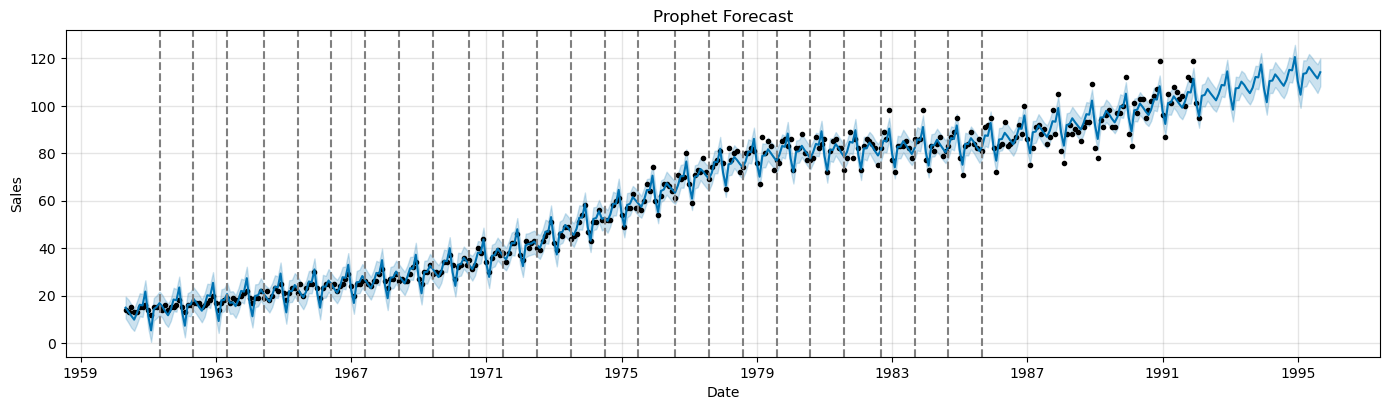

In [94]:
model = Prophet(growth='linear', seasonality_mode='additive', interval_width=0.90)
model.add_country_holidays(country_name='NL') 
model.fit(train)

forecast = model.predict(converted_sales)

fig1 = model.plot(forecast, figsize=(14, 4))
a = add_changepoints_to_plot(fig1.gca(), model, forecast, threshold=0.0, cp_color='gray', trend=False)
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')

### Point 5

Let's take a look at how much the trend actually changes at each automatically detected changepoint:

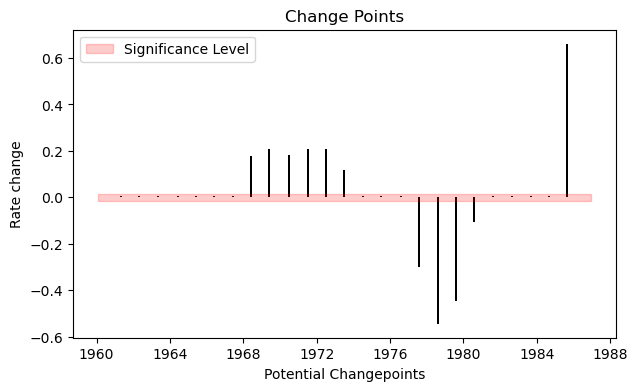

In [95]:
fig, ax = plt.subplots(figsize=(7, 4))
eps = 5e-3  # small offset to improve visualization
ax.bar(model.changepoints, np.nanmean(model.params['delta'], axis=0)+eps, color='k', width=40)
ax.fill_between(ax.get_xlim(), 0.01+eps, -0.01-eps, color='r', alpha=0.2, label='Significance Level')
ax.set_title('Change Points')
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential Changepoints')
plt.legend()
plt.show()

Looks like the prophet is overfitting a bit the trend changepoints. To adjust, we can try to increase changepoint prior scale.

11:41:51 - cmdstanpy - INFO - Chain [1] start processing
11:41:51 - cmdstanpy - INFO - Chain [1] done processing


Text(133.09722222222223, 0.5, 'Sales')

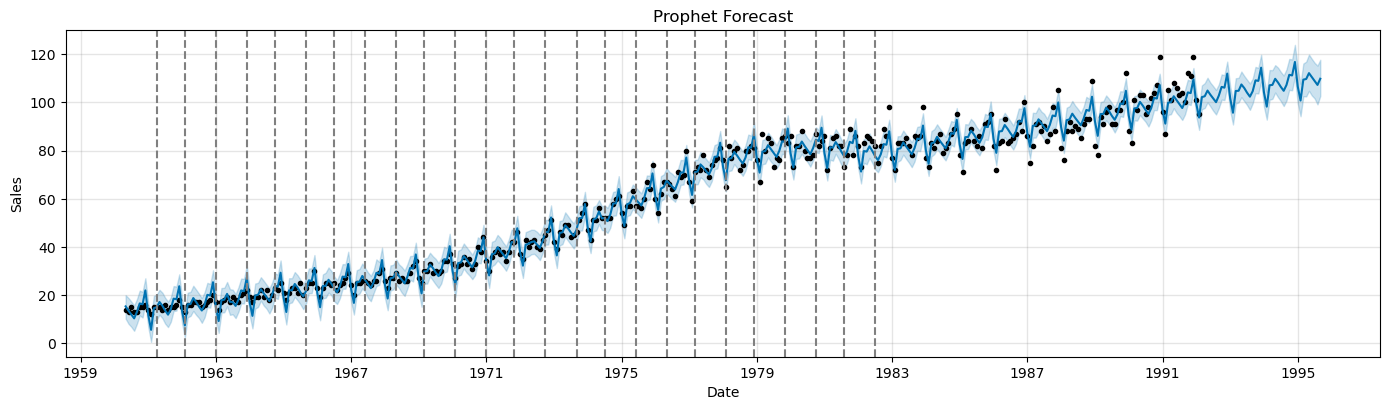

In [96]:
model = Prophet(growth='linear', seasonality_mode='additive', interval_width=0.90, changepoint_prior_scale=0.9, changepoint_range=0.7)
model.add_country_holidays(country_name='NL') 
model.fit(train)

forecast = model.predict(converted_sales)

fig1 = model.plot(forecast, figsize=(14, 4))
a = add_changepoints_to_plot(fig1.gca(), model, forecast, threshold=0.0, cp_color='gray', trend=False)
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')

### Points 6 + 7

First, let's look at MAE and MAPE of the linear prophet model of point 3:

11:41:51 - cmdstanpy - INFO - Chain [1] start processing
11:41:51 - cmdstanpy - INFO - Chain [1] done processing


Linear model MAPE: 0.0438016868849132
Linear model MSE: 34.81848018550525


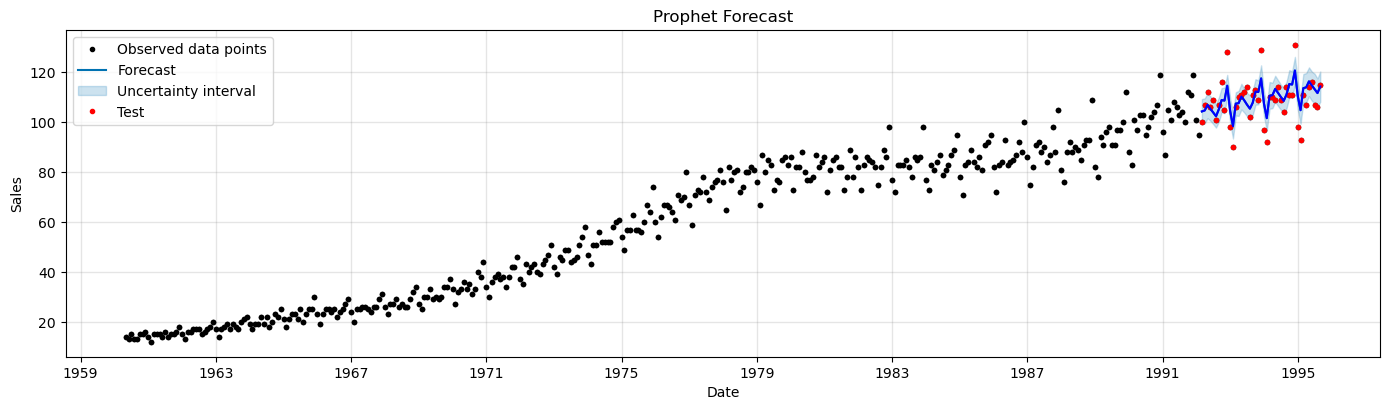

In [97]:
model_linear = Prophet(growth='linear', seasonality_mode='additive', interval_width=0.90)
model_linear.fit(train)
forecast_linear = model_linear.predict(test)

linear_mse = mean_squared_error(test['y'], forecast_linear['yhat'])
linear_mape = mean_absolute_percentage_error(test['y'], forecast_linear['yhat'])
print(f"Linear model MAPE: {linear_mape}")
print(f"Linear model MSE: {linear_mse}")

fig1 = model.plot(forecast_linear, figsize=(14, 4))
plt.plot(converted_sales['ds'], converted_sales['y'], 'k.')
plt.plot(test['ds'], test['y'], 'r.', label='Test')
plt.plot(test['ds'], forecast_linear['yhat'], 'b-')
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

We now need to specify caps for logistic prophet. By visal inspection, a lowe cap of 18 and a higher cap of 120 can be reasonably assumed.

11:43:25 - cmdstanpy - INFO - Chain [1] start processing
11:43:25 - cmdstanpy - INFO - Chain [1] done processing


Linear model MAPE: 0.07044263978574251
Linear model MSE: 88.2003131449673


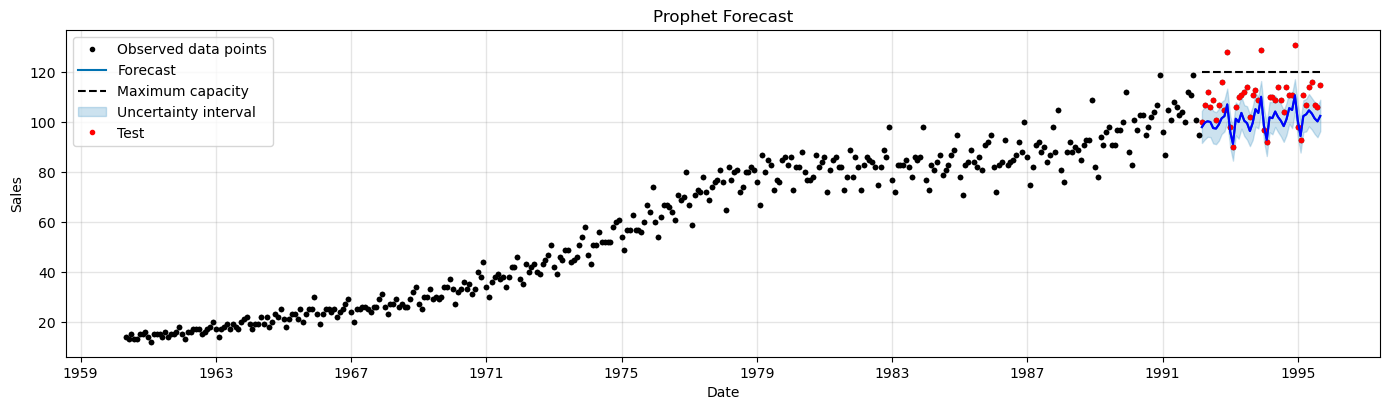

In [101]:
train['cap'] = 120
train['floor'] = 18
test['cap'] = 120
test['floor'] = 18

model_logist = Prophet(growth='logistic', seasonality_mode='additive', interval_width=0.90)
model_logist.fit(train)

forecast_logistic = model_logist.predict(test)
logistic_mse = mean_squared_error(test['y'], forecast_logistic['yhat'])
logistic_mape = mean_absolute_percentage_error(test['y'], forecast_logistic['yhat'])
print(f"Linear model MAPE: {logistic_mape}")
print(f"Linear model MSE: {logistic_mse}")

fig1 = model.plot(forecast_logistic, figsize=(14, 4))
plt.plot(converted_sales['ds'], converted_sales['y'], 'k.')
plt.plot(test['ds'], test['y'], 'r.', label='Test')
plt.plot(test['ds'], forecast_logistic['yhat'], 'b-')
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()


As shown in the above graph, the logistic prophet forecast has a "weaker" trend than the real data

The performances of the logistic model are lower than the linear one.

Possible explainations are:
1) We don't know by default if the true model is linear or saturates arounf certain values.
2) If the model saturates, we cannot infer it from the trianing data alone. Probably, the true saturation value is much higher than what we see in the training data, in this way it is not possible to set a correct high cap for the prophet.

With more data available, we might be able to see around which thresholds the data saturates and select correct caps.

Anothe roption could be to assume very high capacity (let's say, 200) and see if the prediction get better. Note that this is illegal since we are fitting a trainning hyperparameter (the pigher cap) using the test set.

11:43:12 - cmdstanpy - INFO - Chain [1] start processing
11:43:13 - cmdstanpy - INFO - Chain [1] done processing


Linear model MAPE: 0.041765685728885796
Linear model MSE: 36.46451322718813


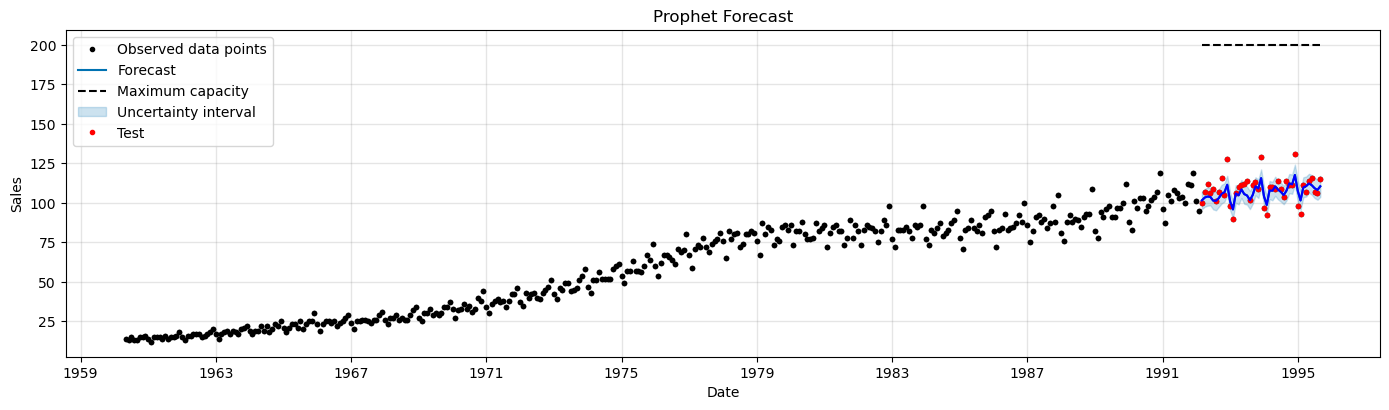

In [100]:
train['cap'] = 200
train['floor'] = 18
test['cap'] = 200
test['floor'] = 18

model_logist = Prophet(growth='logistic', seasonality_mode='additive', interval_width=0.90)
model_logist.fit(train)

forecast_logistic = model_logist.predict(test)
logistic_mse = mean_squared_error(test['y'], forecast_logistic['yhat'])
logistic_mape = mean_absolute_percentage_error(test['y'], forecast_logistic['yhat'])
print(f"Linear model MAPE: {logistic_mape}")
print(f"Linear model MSE: {logistic_mse}")

fig1 = model.plot(forecast_logistic, figsize=(14, 4))
plt.plot(converted_sales['ds'], converted_sales['y'], 'k.')
plt.plot(test['ds'], test['y'], 'r.', label='Test')
plt.plot(test['ds'], forecast_logistic['yhat'], 'b-')
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()


The prediction is now much more accurate, with almost identical performances with respect to the linear prophet.

This still does not make the logistic prophet viable, since by setting a very hight threshold prophet is operating in the middle of the (sigmoid shaped) logistic growth curve. Here the trend has a linear behaviour, making this prophet equivalent to the linear one.

For this reason I would conclude that, it is always better to use a linear prophet.